# Ultimate beginner's guide to GANs 👨🏽‍💻

In this notebook you'll learn:

✅ What are GANs exactly? <br/>
✅ How to train them? <br/>
✅ How to use them? <br/>

After you complete this one you'll have a much better understanding of GANs!

So, let's start!

---

## What the heck are GANs and how they came to be?

GANs were originally proposed by Ian Goodfellow et al. in a seminal paper called [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf).

(`et al.` - fancy Latin phrase you'll be seing around it means `and others`)

You DON'T need to understand the paper in order to understand this notebook. That being said:

---

GANs are a `framework` where 2 models (usually `neural networks`), called `generator (G)` and `discriminator (D)`, play a `minimax game` against each other. The generator is trying to learn the `distribution of real data` and is the network which we're usually interested in. During the game the goal of the generator is to trick the discriminator into "thinking" that the images it generates is real. The goal of the discriminator, on the other hand, is to correctly discriminate between the generated (fake) images and real images coming from some dataset (e.g. MNIST). 

At the equilibrium of the game the generator learns to generate images indistinguishable from the real images and the best that discriminator can do is output 0.5 - meaning it's 50% sure that what you gave him is a real image (and 50% sure that it's fake) - i.e. it doesn't have a clue of what's happening!

Potentially confusing parts: <br/><br/>
`minimax game` - basically they have some goal (objective function) and one is trying to minimize it, the other to maximize it, that's it. <br/><br/>
`distribution of real data` - basically you can think of any data you use as a point in the `n-dimensional` space. For example, MNIST 28x28 image when flattened has 784 numbers. So 1 image is simply a point in the 784-dimensional space. That's it. when I say `n` in order to visualize it just think of `3` or `2` dimensions - that's how everybody does it. So you can think of your data as a 3D/2D cloud of points. Each point has some probability associated with it - how likely is it to appear - that's the `distribution` part. So if your model has internal representation of this 3D/2D point cloud there is nothing stopping it from generating more points from that cloud! And those are new images (be it human faces, digits or whatever) that never existed!

<img src="data/examples/jupyter/data_distribution.PNG" alt="example of a simple 2D data distribution" align="center" style="width: 550px;"/> <br/>

Here is an example of a simple data distribution. The data here is 2-dimensional and the height of the plot is the probability of certain datapoint appearing. You can see that points around (0, 0) have the highest probability of happening. Those datapoints could be your 784-dimensional images projected into 2-dimensional space via PCA, t-SNE, UMAP, etc. (you don't need to know what these are, they are just some dimensionality reduction methods out there).

In reality this plot would have multiple peaks (`multi-modal`) and wouldn't be this nice.


---

That was everything you need to know for now as a beginner! Let's code!



In [1]:
# I always like to structure my imports into Python's native libs,
# stuff I installed via conda/pip and local file imports (we don't have those here)
import os
import re
import time
import enum


import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import git


import torch
from torch import nn
from torch.optim import Adam
from torchvision import transforms, datasets
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Let's create some constant to make stuff a bit easier
BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries')  # location where trained models are located
CHECKPOINTS_PATH = os.path.join(os.getcwd(), 'models', 'checkpoints')  # semi-trained models during training will be dumped here
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')  # all data both input (MNIST) and generated will be stored here
DEBUG_IMAGERY_PATH = os.path.join(DATA_DIR_PATH, 'debug_imagery')  # we'll be dumping images here during GAN training

MNIST_IMG_SIZE = 28  # MNIST images have 28x28 resolution, it's just convinient to put this into a constant you'll see later why

## Understand your data - Become One With Your Data!

You should always invest time to understand your data. You should be able to answer questions like:
1. How many images do I have?
2. What's the shape of my image?
3. How do my images look like?

So let's first answer those questions!

Dataset size: 60000 images.
Image shape torch.Size([1, 28, 28])


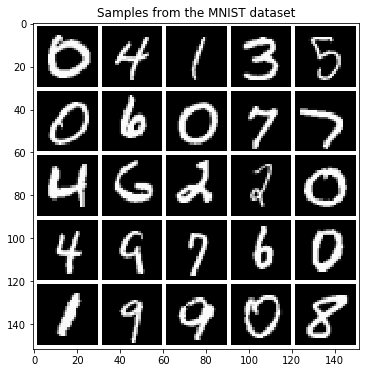

In [3]:
batch_size = 128

# Images are usually in the [0., 1.] or [0, 255] range, Normalize transform will bring them into [-1, 1] range
# It's one of those things somebody figured out experimentally that it works (without special theoretical arguments)
# https://github.com/soumith/ganhacks <- you can find more of those hacks here
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((.5,), (.5,))  
    ])

# MNIST is a super simple, "hello world" dataset so it's included in PyTorch.
# First time you run this it will download the MNIST dataset and store it in DATA_DIR_PATH
# the 'transform' (defined above) will be applied to every single image
mnist_dataset = datasets.MNIST(root=DATA_DIR_PATH, train=True, download=True, transform=transform)

# Nice wrapper class helps us load images in batches (suitable for GPUs)
mnist_data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Let's answer our questions

# Q1: How many images do I have?
print(f'Dataset size: {len(mnist_dataset)} images.')

num_imgs_to_visualize = 25  # number of images we'll display
batch = next(iter(mnist_data_loader))  # take a single batch from the dataset
img_batch = batch[0]  # extract only images and ignore the labels (batch[1])
img_batch_subset = img_batch[:num_imgs_to_visualize]  # extract only a subset of images

# Q2: What's the shape of my image?
# format is (B,C,H,W), B - number of images in batch, C - number of channels, H - height, W - width
print(f'Image shape {img_batch_subset.shape[1:]}')  # we ignore shape[0] - number of imgs in batch.

# Q3: How do my images look like?
# Creates a 5x5 grid of images, normalize will bring images from [-1, 1] range back into [0, 1] for display
# pad_value is 1. (white) because it's 0. (black) by default but since our background is also black,
# we wouldn't see the grid pattern so I set it to 1.
grid = make_grid(img_batch_subset, nrow=int(np.sqrt(num_imgs_to_visualize)), normalize=True, pad_value=1.)
grid = np.moveaxis(grid.numpy(), 0, 2)  # from CHW -> HWC format that's what matplotlib expects! Get used to this.
plt.figure(figsize=(6, 6))
plt.title("Samples from the MNIST dataset")
plt.imshow(grid)
plt.show()

## Understand your model (neural networks)!

Let's define the generator and discriminator networks!

The original paper used the maxout activation and dropout for regularization (you don't need to understand this). <br/>
I'm using `LeakyReLU` instead and `batch normalization` which came after the original paper was published.

Those design decisions are inspired by the DCGAN model which came later than the original GAN.

In [4]:
# Size of the generator's input vector. Generator will eventually learn how to map these into meaningful images!
LATENT_SPACE_DIM = 100


# This one will produce a batch of those vectors
def get_gaussian_latent_batch(batch_size, device):
    return torch.randn((batch_size, LATENT_SPACE_DIM), device=device)


# It's cleaner if you define the block like this - bear with me
def vanilla_block(in_feat, out_feat, normalize=True, activation=None):
    layers = [nn.Linear(in_feat, out_feat)]
    if normalize:
        layers.append(nn.BatchNorm1d(out_feat))
    # 0.2 was used in DCGAN, I experimented with other values like 0.5 didn't notice significant change
    layers.append(nn.LeakyReLU(0.2) if activation is None else activation)
    return layers


class GeneratorNet(torch.nn.Module):
    """Simple 4-layer MLP generative neural network.

    By default it works for MNIST size images (28x28).

    There are many ways you can construct generator to work on MNIST.
    Even without normalization layers it will work ok. Even with 5 layers it will work ok, etc.

    It's generally an open-research question on how to evaluate GANs i.e. quantify that "ok" statement.

    People tried to automate the task using IS (inception score, often used incorrectly), etc.
    but so far it always ends up with some form of visual inspection (human in the loop).
    
    Fancy way of saying you'll have to take a look at the images from your generator and say hey this looks good!

    """

    def __init__(self, img_shape=(MNIST_IMG_SIZE, MNIST_IMG_SIZE)):
        super().__init__()
        self.generated_img_shape = img_shape
        num_neurons_per_layer = [LATENT_SPACE_DIM, 256, 512, 1024, img_shape[0] * img_shape[1]]

        # Now you see why it's nice to define blocks - it's super concise!
        # These are pretty much just linear layers followed by LeakyReLU and batch normalization
        # Except for the last layer where we exclude batch normalization and we add Tanh (maps images into our [-1, 1] range!)
        self.net = nn.Sequential(
            *vanilla_block(num_neurons_per_layer[0], num_neurons_per_layer[1]),
            *vanilla_block(num_neurons_per_layer[1], num_neurons_per_layer[2]),
            *vanilla_block(num_neurons_per_layer[2], num_neurons_per_layer[3]),
            *vanilla_block(num_neurons_per_layer[3], num_neurons_per_layer[4], normalize=False, activation=nn.Tanh())
        )

    def forward(self, latent_vector_batch):
        img_batch_flattened = self.net(latent_vector_batch)
        # just un-flatten using view into (N, 1, 28, 28) shape for MNIST
        return img_batch_flattened.view(img_batch_flattened.shape[0], 1, *self.generated_img_shape)


# You can interpret the output from the discriminator as a probability and the question it should
# give an answer to is "hey is this image real?". If it outputs 1. it's 100% sure it's real. 0.5 - 50% sure, etc.
class DiscriminatorNet(torch.nn.Module):
    """Simple 3-layer MLP discriminative neural network. It should output probability 1. for real images and 0. for fakes.

    By default it works for MNIST size images (28x28).

    Again there are many ways you can construct discriminator network that would work on MNIST.
    You could use more or less layers, etc. Using normalization as in the DCGAN paper doesn't work well though.

    """

    def __init__(self, img_shape=(MNIST_IMG_SIZE, MNIST_IMG_SIZE)):
        super().__init__()
        num_neurons_per_layer = [img_shape[0] * img_shape[1], 512, 256, 1]

        # Last layer is Sigmoid function - basically the goal of the discriminator is to output 1.
        # for real images and 0. for fake images and sigmoid is clamped between 0 and 1 so it's perfect.
        self.net = nn.Sequential(
            *vanilla_block(num_neurons_per_layer[0], num_neurons_per_layer[1], normalize=False),
            *vanilla_block(num_neurons_per_layer[1], num_neurons_per_layer[2], normalize=False),
            *vanilla_block(num_neurons_per_layer[2], num_neurons_per_layer[3], normalize=False, activation=nn.Sigmoid())
        )

    def forward(self, img_batch):
        img_batch_flattened = img_batch.view(img_batch.shape[0], -1)  # flatten from (N,1,H,W) into (N, HxW)
        return self.net(img_batch_flattened)

## GAN Training

**Feel free to skip this entire section** if you just want to use the pre-trained model to generate some new images - which don't exist in the original MNIST dataset and that's the whole magic of GANs!

Phew, so far we got familiar with data and our models, awesome work! <br/>
But brace yourselves as this is arguable the hardest part. How to actually train your GAN?

Let's start with understanding the loss function! We'll be using `BCE (binary cross-entropy loss`), let's see why? <br/>

If we input real images into the discriminator we expect it to output 1 (I'm 100% sure that this is a real image). <br/>
The further away it is from 1 and the closer it is to 0 the more we should penalize it, as it is making wrong prediction. <br/>
So this is how the loss should look like in that case (it's basically `-log(x)`):

<img src="data/examples/jupyter/cross_entropy_loss.png" alt="BCE loss when true label = 1." align="left"/> <br/>

BCE loss basically becomes `-log(x)` when it's target (true) label is 1. <br/>

Similarly for fake images, the target (true) label is 0 (as we want the discriminator to output 0 for fake images) and we want to penalize the generator if it starts outputing values close to 1. So we basically want to mirror the above loss function and that's just: `-log(1-x)`. <br/>

BCE loss basically becomes `-log(1-x)` when it's target (true) label is 0. That's why it perfectly fits the task! <br/>


### Training utility functions
Let's define some useful utility functions:

In [5]:
# Tried SGD for the discriminator, had problems tweaking it - Adam simply works nicely but default lr 1e-3 won't work!
# I had to train discriminator more (4 to 1 schedule worked) to get it working with default lr, still got worse results.
# 0.0002 and 0.5, 0.999 are from the DCGAN paper it works here nicely!
def get_optimizers(d_net, g_net):
    d_opt = Adam(d_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
    g_opt = Adam(g_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
    return d_opt, g_opt


# It's useful to add some metadata when saving your model, it should probably make sense to also add the number of epochs
def get_training_state(generator_net, gan_type_name):
    training_state = {
        "commit_hash": git.Repo(search_parent_directories=True).head.object.hexsha,
        "state_dict": generator_net.state_dict(),
        "gan_type": gan_type_name
    }
    return training_state


# Makes things useful when you have multiple models
class GANType(enum.Enum):
    VANILLA = 0


# Feel free to ignore this one not important for GAN training. 
# It just figures out a good binary name so as not to overwrite your older models.
def get_available_binary_name(gan_type_enum=GANType.VANILLA):
    def valid_binary_name(binary_name):
        # First time you see raw f-string? Don't worry the only trick is to double the brackets.
        pattern = re.compile(rf'{gan_type_enum.name}_[0-9]{{6}}\.pth')
        return re.fullmatch(pattern, binary_name) is not None

    prefix = gan_type_enum.name
    # Just list the existing binaries so that we don't overwrite them but write to a new one
    valid_binary_names = list(filter(valid_binary_name, os.listdir(BINARIES_PATH)))
    if len(valid_binary_names) > 0:
        last_binary_name = sorted(valid_binary_names)[-1]
        new_suffix = int(last_binary_name.split('.')[0][-6:]) + 1  # increment by 1
        return f'{prefix}_{str(new_suffix).zfill(6)}.pth'
    else:
        return f'{prefix}_000000.pth'

### Tracking your model's progress during training
You can track how your GAN training is progressing through:
1. Console output
2. Images dumped to: `data/debug_imagery`
3. Tensorboard, just type in `tensorboard --logdir=runs` to your Anaconda console 

Note: to use tensorboard just navigate to project root first via `cd path_to_root` and open `http://localhost:6006/` (browser)

In [ ]:
####################### constants #####################
# For logging purpose
ref_batch_size = 16
ref_noise_batch = get_gaussian_latent_batch(ref_batch_size, device)  # Track G's quality during training on fixed noise vectors

discriminator_loss_values = []
generator_loss_values = []

img_cnt = 0

enable_tensorboard = True
console_log_freq = 50
debug_imagery_log_freq = 50
checkpoint_freq = 2

# For training purpose
num_epochs = 10  # feel free to increase this

########################################################

writer = SummaryWriter()  # (tensorboard) writer will output to ./runs/ directory by default

# Hopefully you have some GPU ^^
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare feed-forward nets (place them on GPU if present) and optimizers which will tweak their weights
discriminator_net = DiscriminatorNet().train().to(device)
generator_net = GeneratorNet().train().to(device)

discriminator_opt, generator_opt = get_optimizers(discriminator_net, generator_net)

# 1s (real_images_gt) will configure BCELoss into -log(x) (check out the loss image above that's -log(x)) 
# whereas 0s (fake_images_gt) will configure it to -log(1-x)
# So that means we can effectively use binary cross-entropy loss to achieve adversarial loss!
adversarial_loss = nn.BCELoss()
real_images_gt = torch.ones((batch_size, 1), device=device)
fake_images_gt = torch.zeros((batch_size, 1), device=device)

ts = time.time()  # start measuring time

# GAN training loop, it's always smart to first train the discriminator so as to avoid mode collapse!
# A mode collapse, for example, is when your generator learns to only generate a single digit instead of all 10 digits!
for epoch in range(num_epochs):
    for batch_idx, (real_images, _) in enumerate(mnist_data_loader):

        real_images = real_images.to(device)  # Place imagery on GPU (if present)

        #
        # Train discriminator: maximize V = log(D(x)) + log(1-D(G(z))) or equivalently minimize -V
        # Note: D = discriminator, x = real images, G = generator, z = latent Gaussian vectors, G(z) = fake images
        #

        # Zero out .grad variables in discriminator network,
        # otherwise we would have corrupt results - leftover gradients from the previous training iteration
        discriminator_opt.zero_grad()

        # -log(D(x)) <- we minimize this by making D(x)/discriminator_net(real_images) as close to 1 as possible
        real_discriminator_loss = adversarial_loss(discriminator_net(real_images), real_images_gt)

        # G(z) | G == generator_net and z == get_gaussian_latent_batch(batch_size, device)
        fake_images = generator_net(get_gaussian_latent_batch(batch_size, device))
        # D(G(z)), we call detach() so that we don't calculate gradients for the generator during backward()
        fake_images_predictions = discriminator_net(fake_images.detach())
        # -log(1 - D(G(z))) <- we minimize this by making D(G(z)) as close to 0 as possible
        fake_discriminator_loss = adversarial_loss(fake_images_predictions, fake_images_gt)

        discriminator_loss = real_discriminator_loss + fake_discriminator_loss
        discriminator_loss.backward()  # this will populate .grad vars in the discriminator net
        discriminator_opt.step()  # perform D weights update according to optimizer's strategy

        #
        # Train generator: minimize V1 = log(1-D(G(z))) or equivalently maximize V2 = log(D(G(z))) (or min of -V2)
        # The original expression (V1) had problems with diminishing gradients for G when D is too good.
        #

        # if you want to cause mode collapse probably the easiest way to do that would be to add "for i in range(n)"
        # here (simply train G more frequent than D), n = 10 worked for me other values will also work - experiment.

        # Zero out .grad variables in discriminator network (otherwise we would have corrupt results)
        generator_opt.zero_grad()

        # D(G(z)) (see above for explanations)
        generated_images_predictions = discriminator_net(generator_net(get_gaussian_latent_batch(batch_size, device)))
        # By placing real_images_gt here we minimize -log(D(G(z))) which happens when D approaches 1
        # i.e. we're tricking D into thinking that these generated images are real!
        generator_loss = adversarial_loss(generated_images_predictions, real_images_gt)

        generator_loss.backward()  # this will populate .grad vars in the G net (also in D but we won't use those)
        generator_opt.step()  # perform G weights update according to optimizer's strategy

        #
        # Logging and checkpoint creation
        #

        generator_loss_values.append(generator_loss.item())
        discriminator_loss_values.append(discriminator_loss.item())
        
        if enable_tensorboard:
            global_batch_idx = len(mnist_data_loader) * epoch + batch_idx + 1
            writer.add_scalars('losses/g-and-d', {'g': generator_loss.item(), 'd': discriminator_loss.item()}, global_batch_idx)
            # Save debug imagery to tensorboard also (some redundancy but it may be more beginner-friendly)
            if batch_idx % debug_imagery_log_freq == 0:
                with torch.no_grad():
                    log_generated_images = generator_net(ref_noise_batch)
                    log_generated_images = nn.Upsample(scale_factor=2, mode='nearest')(log_generated_images)
                    intermediate_imagery_grid = make_grid(log_generated_images, nrow=int(np.sqrt(ref_batch_size)), normalize=True)
                    writer.add_image('intermediate generated imagery', intermediate_imagery_grid, global_batch_idx)

        if batch_idx % console_log_freq == 0:
            prefix = 'GAN training: time elapsed'
            print(f'{prefix} = {(time.time() - ts):.2f} [s] | epoch={epoch + 1} | batch= [{batch_idx + 1}/{len(mnist_data_loader)}]')

        # Save intermediate generator images (more convenient like this than through tensorboard)
        if batch_idx % debug_imagery_log_freq == 0:
            with torch.no_grad():
                log_generated_images = generator_net(ref_noise_batch)
                log_generated_images_resized = nn.Upsample(scale_factor=2.5, mode='nearest')(log_generated_images)
                out_path = os.path.join(DEBUG_IMAGERY_PATH, f'{str(img_cnt).zfill(6)}.jpg')
                save_image(log_generated_images_resized, out_path, nrow=int(np.sqrt(ref_batch_size)), normalize=True)
                img_cnt += 1

        # Save generator checkpoint
        if (epoch + 1) % checkpoint_freq == 0 and batch_idx == 0:
            ckpt_model_name = f"vanilla_ckpt_epoch_{epoch + 1}_batch_{batch_idx + 1}.pth"
            torch.save(get_training_state(generator_net, GANType.VANILLA.name), os.path.join(CHECKPOINTS_PATH, ckpt_model_name))

# Save the latest generator in the binaries directory
torch.save(get_training_state(generator_net, GANType.VANILLA.name), os.path.join(BINARIES_PATH, get_available_binary_name()))


## Generate images with your vanilla GAN

Nice, finally we can use the generator we trained to generate some MNIST-like imagery!

Let's define a couple of utility functions which will make things cleaner!

In [7]:
def postprocess_generated_img(generated_img_tensor):
    assert isinstance(generated_img_tensor, torch.Tensor), f'Expected PyTorch tensor but got {type(generated_img_tensor)}.'

    # Move the tensor from GPU to CPU, convert to numpy array, extract 0th batch, move the image channel
    # from 0th to 2nd position (CHW -> HWC)
    generated_img = np.moveaxis(generated_img_tensor.to('cpu').numpy()[0], 0, 2)

    # Since MNIST images are grayscale (1-channel only) repeat 3 times to get RGB image
    generated_img = np.repeat(generated_img,  3, axis=2)

    # Imagery is in the range [-1, 1] (generator has tanh as the output activation) move it into [0, 1] range
    generated_img -= np.min(generated_img)
    generated_img /= np.max(generated_img)

    return generated_img


# This function will generate a random vector pass it to the generator which will generate a new image
# which we will just post-process and return it
def generate_from_random_latent_vector(generator):
    with torch.no_grad():  # Tells PyTorch not to compute gradients which would have huge memory footprint
        
        # Generate a single random (latent) vector
        latent_vector = get_gaussian_latent_batch(1, next(generator.parameters()).device)
        
        # Post process generator output (as it's in the [-1, 1] range, remember?)
        generated_img = postprocess_generated_img(generator(latent_vector))

    return generated_img


# You don't need to get deep into this one - irrelevant for GANs - it will just figure out a good name for your generated
# images so that you don't overwrite the old ones. They'll be stored with xxxxxx.jpg naming scheme.
def get_available_file_name(input_dir): 
    def valid_frame_name(str):
        pattern = re.compile(r'[0-9]{6}\.jpg')  # regex, examples it covers: 000000.jpg or 923492.jpg, etc.
        return re.fullmatch(pattern, str) is not None

    # Filter out only images with xxxxxx.jpg format from the input_dir
    valid_frames = list(filter(valid_frame_name, os.listdir(input_dir)))
    if len(valid_frames) > 0:
        # Images are saved in the <xxxxxx>.jpg format we find the biggest such <xxxxxx> number and increment by 1
        last_img_name = sorted(valid_frames)[-1]
        new_prefix = int(last_img_name.split('.')[0]) + 1  # increment by 1
        return f'{str(new_prefix).zfill(6)}.jpg'
    else:
        return '000000.jpg'


def save_and_maybe_display_image(dump_dir, dump_img, out_res=(256, 256), should_display=False):
    assert isinstance(dump_img, np.ndarray), f'Expected numpy array got {type(dump_img)}.'

    # step1: get next valid image name
    dump_img_name = get_available_file_name(dump_dir)

    # step2: convert to uint8 format <- OpenCV expects it otherwise your image will be completely black. Don't ask...
    if dump_img.dtype != np.uint8:
        dump_img = (dump_img*255).astype(np.uint8)

    # step3: write image to the file system (::-1 because opencv expects BGR (and not RGB) format...)
    cv.imwrite(os.path.join(dump_dir, dump_img_name), cv.resize(dump_img[:, :, ::-1], out_res, interpolation=cv.INTER_NEAREST))  

    # step4: maybe display part of the function
    if should_display:
        plt.imshow(dump_img)
        plt.show()

### We're now ready to generate some new digit images!

Model states contains this data: dict_keys(['commit_hash', 'state_dict', 'gan_type'])
Using VANILLA GAN!
Generating new MNIST-like images!


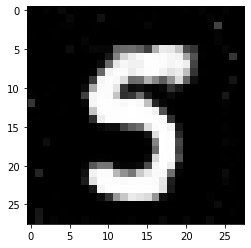

In [10]:
# VANILLA_000000.pth is the model I pretrained for you, feel free to change it if you trained your own model (last section)!
model_path = os.path.join(BINARIES_PATH, 'VANILLA_000000.pth')  
assert os.path.exists(model_path), f'Could not find the model {model_path}. You first need to train your generator.'

# Hopefully you have some GPU ^^
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# let's load the model, this is a dictionary containing model weights but also some metadata
# commit_hash - simply tells me which version of my code generated this model (hey you have to learn git!)
# gan_type - this one is "VANILLA" but I also have "DCGAN" and "cGAN" models
# state_dict - contains the actuall neural network weights
model_state = torch.load(model_path)  
print(f'Model states contains this data: {model_state.keys()}')

gan_type = model_state["gan_type"]  # 
print(f'Using {gan_type} GAN!')

# Let's instantiate a generator net and place it on GPU (if you have one)
generator = GeneratorNet().to(device)
# Load the weights, strict=True just makes sure that the architecture corresponds to the weights 100%
generator.load_state_dict(model_state["state_dict"], strict=True)
generator.eval()  # puts some layers like batch norm in a good state so it's ready for inference <- fancy name right?
    
generated_imgs_path = os.path.join(DATA_DIR_PATH, 'generated_imagery')  # this is where we'll dump images
os.makedirs(generated_imgs_path, exist_ok=True)

#
# This is where the magic happens!
#

print('Generating new MNIST-like images!')
generated_img = generate_from_random_latent_vector(generator)
save_and_maybe_display_image(generated_imgs_path, generated_img, should_display=True)

# I'd love to hear your feedback

If you found this notebook useful and would like me to add the same for cGAN and DCGAN please [open an issue](https://github.com/gordicaleksa/pytorch-gans/issues/new). <br/>

I'm super not aware of how useful people find this, I usually do stuff through my IDE.

# Connect with me

I share lots of useful (I hope so at least!) content on LinkedIn, Twitter, YouTube and Medium. <br/>
So feel free to connect with me there:
1. My [LinkedIn](https://www.linkedin.com/in/aleksagordic) and [Twitter](https://twitter.com/gordic_aleksa) profiles
2. My YouTube channel - [The AI Epiphany](https://www.youtube.com/c/TheAiEpiphany)
3. My [Medium](https://gordicaleksa.medium.com/) profile
